## Import library

In [1]:
import json
import numpy as np
from joblib import load
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

## Implement evaluator

In [2]:
class CRFEvaluator:
    def __init__(self, model_path):
        self.model = load(model_path)
        self.labels = ['B-Cus', 'I-Cus', 'B-Address', "I-Address", 'B-Phone', 'O', 'B-Payment', 'I-Payment']

    def word2features(self, sentence, i):
        word = sentence[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = sentence[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.isupper()': word1.isupper(),
                '-1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['BOS'] = True

        if i < len(sentence)-1:
            word1 = sentence[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.isupper()': word1.isupper(),
                '+1:word.isdigit()': word1.isdigit(),
            })
        else:
            features['EOS'] = True
            
        return features

    def sentence_features(self, words):
        return [self.word2features(words, i) for i in range(len(words))]

    def sentence_labels(self, labels):
        return labels
    
    def load_data_from_json(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return [(
            item['words'], 
            item['label']
        ) for item in data]
    
    def evaluate_accuracy(self, test_data_path):
        test_data = self.load_data_from_json(test_data_path)
        X_test = [self.sentence_features(s[0]) for s in test_data]
        y_test = [self.sentence_labels(s[1]) for s in test_data]
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(list(chain(*y_test)), list(chain(*y_pred)))
        return accuracy

    def plot_confusion_matrix(self, test_data_path, title):
        test_data = self.load_data_from_json(test_data_path)
        X_test = [self.sentence_features(s[0]) for s in test_data]
        y_test = [self.sentence_labels(s[1]) for s in test_data]
        y_pred = self.model.predict(X_test)
        y_test_flat = list(chain(*y_test))
        y_pred_flat = list(chain(*y_pred))
        cm = confusion_matrix(y_test_flat, y_pred_flat, labels=self.labels)

        fig, ax = plt.subplots(figsize=(10, 7))
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=self.labels, yticklabels=self.labels,
               title='Confusion Matrix of ' + title,
               ylabel='True label',
               xlabel='Predicted label')

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2 else "black")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        plt.show()

    def plot_roc_auc(self, test_data_path, title):
        test_data = self.load_data_from_json(test_data_path)
        X_test = [self.sentence_features(s[0]) for s in test_data]
        y_test = [self.sentence_labels(s[1]) for s in test_data]
        y_pred = self.model.predict(X_test)
        y_test_binarized = label_binarize(list(chain(*y_test)), classes=self.labels)
        y_pred_binarized = label_binarize(list(chain(*y_pred)), classes=self.labels)

        fpr, tpr, roc_auc = {}, {}, {}
        for i, label in enumerate(self.labels):
            fpr[label], tpr[label], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
            roc_auc[label] = auc(fpr[label], tpr[label])

        plt.figure()
        for label in self.labels:
            plt.plot(fpr[label], tpr[label], label=f'{label} (area = {roc_auc[label]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC/AUC of " + title)
        plt.legend(loc="lower right")
        plt.show()

    def print_classification_report(self, test_data_path):
        test_data = self.load_data_from_json(test_data_path)
        X_test = [self.sentence_features(s[0]) for s in test_data]
        y_test = [self.sentence_labels(s[1]) for s in test_data]
        y_pred = self.model.predict(X_test)
        y_test_flat = list(chain(*y_test))
        y_pred_flat = list(chain(*y_pred))
        report = classification_report(y_test_flat, y_pred_flat, labels=self.labels, target_names=self.labels)
        print(report)

## Evaluation

#### Case 1: Data which is 100% generated by ChatGPT 3.5

In [3]:
case_1_model = CRFEvaluator('../output/savedmodels/customer_info_entity_case_1.h5')

In [4]:
accuracy_on_chatgpt_test = case_1_model.evaluate_accuracy("../data/labeled/entity/cus_info/test_gpt.json")
accuracy_on_human_test = case_1_model.evaluate_accuracy("../data/labeled/entity/cus_info/test_human.json")
print("Accuracy on ChatGPT generated testing dataset: ", round(accuracy_on_chatgpt_test * 100, 2))
print("Accuracy on human written testing dataset: ", round(accuracy_on_human_test * 100, 2))

Accuracy on ChatGPT generated testing dataset:  99.38
Accuracy on human written testing dataset:  76.55


In [5]:
print("Classification report on ChatGPT generated testing dataset:")
case_1_model.print_classification_report("../data/labeled/entity/cus_info/test_gpt.json")

print("Classification report on human written testing dataset:")
case_1_model.print_classification_report("../data/labeled/entity/cus_info/test_human.json")

Classification report on ChatGPT generated testing dataset:
              precision    recall  f1-score   support

       B-Cus       0.98      0.96      0.97       222
       I-Cus       0.98      0.97      0.98        62
   B-Address       1.00      1.00      1.00       948
   I-Address       1.00      1.00      1.00      1222
     B-Phone       1.00      0.99      1.00       194
           O       0.99      0.99      0.99      1023
   B-Payment       0.99      0.99      0.99       179
   I-Payment       1.00      0.80      0.89         5

    accuracy                           0.99      3855
   macro avg       0.99      0.96      0.98      3855
weighted avg       0.99      0.99      0.99      3855

Classification report on human written testing dataset:
              precision    recall  f1-score   support

       B-Cus       0.39      0.78      0.52        98
       I-Cus       0.21      0.38      0.27        13
   B-Address       0.72      0.67      0.69       340
   I-Address    

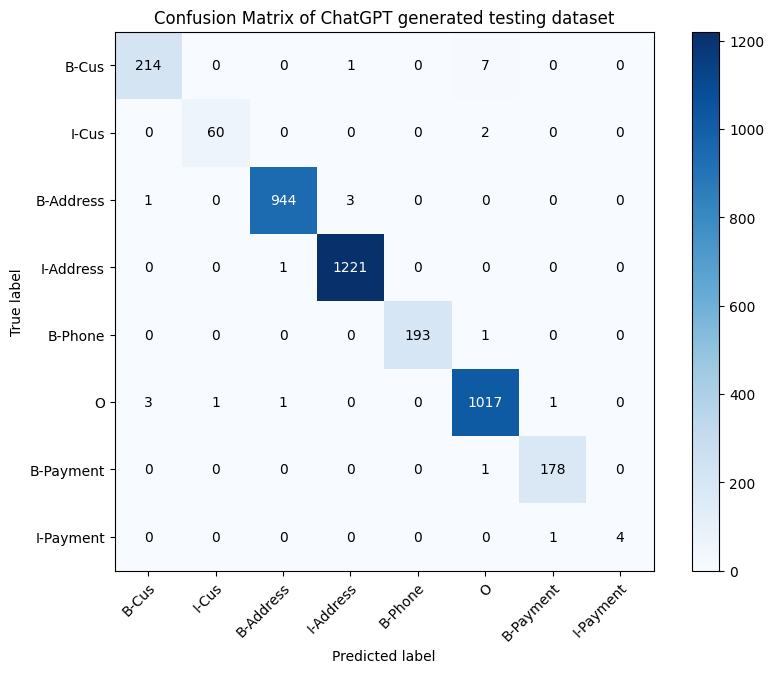

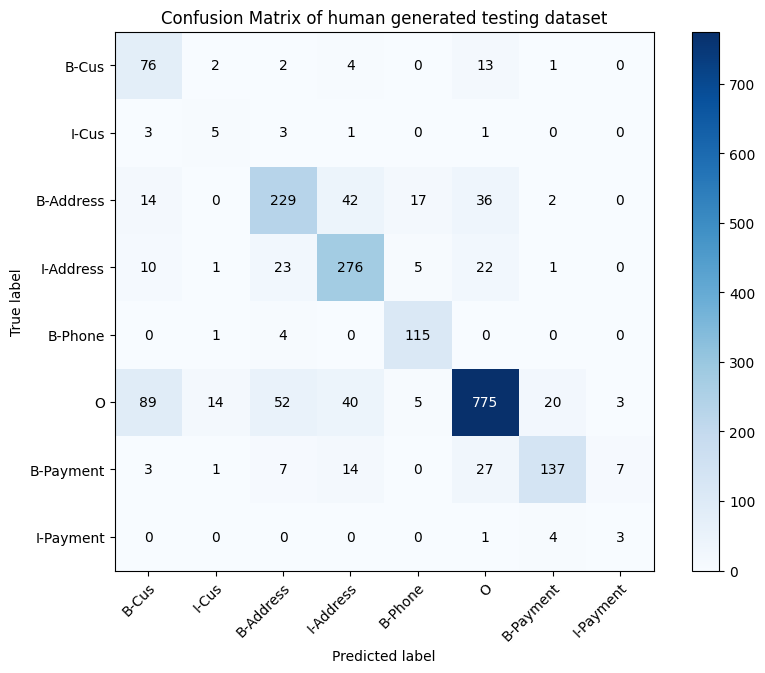

In [6]:
case_1_model.plot_confusion_matrix("../data/labeled/entity/cus_info/test_gpt.json", "ChatGPT generated testing dataset")
case_1_model.plot_confusion_matrix("../data/labeled/entity/cus_info/test_human.json", "human generated testing dataset")

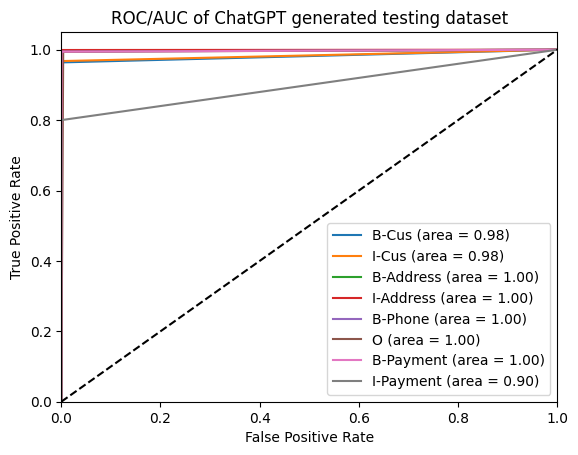

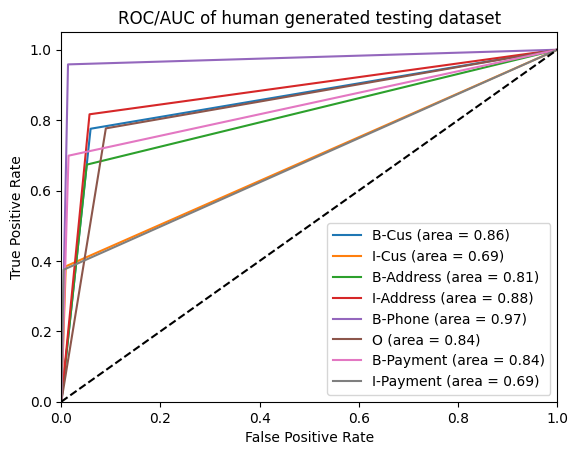

In [7]:
case_1_model.plot_roc_auc("../data/labeled/entity/cus_info/test_gpt.json", "ChatGPT generated testing dataset")
case_1_model.plot_roc_auc("../data/labeled/entity/cus_info/test_human.json", "human generated testing dataset")

#### Case 2: Data which is 100% written by human

In [8]:
case_2_model = CRFEvaluator('../output/savedmodels/customer_info_entity_case_2.h5')

In [9]:
accuracy_on_chatgpt_test = case_2_model.evaluate_accuracy("../data/labeled/entity/cus_info/test_gpt.json")
accuracy_on_human_test = case_2_model.evaluate_accuracy("../data/labeled/entity/cus_info/test_human.json")
print("Accuracy on ChatGPT generated testing dataset: ", round(accuracy_on_chatgpt_test * 100, 2))
print("Accuracy on human written testing dataset: ", round(accuracy_on_human_test * 100, 2))

Accuracy on ChatGPT generated testing dataset:  98.81
Accuracy on human written testing dataset:  91.76


In [10]:
print("Classification report on ChatGPT generated testing dataset:")
case_2_model.print_classification_report("../data/labeled/entity/cus_info/test_gpt.json")

print("Classification report on human written testing dataset:")
case_2_model.print_classification_report("../data/labeled/entity/cus_info/test_human.json")

Classification report on ChatGPT generated testing dataset:
              precision    recall  f1-score   support

       B-Cus       1.00      0.91      0.95       222
       I-Cus       1.00      0.94      0.97        62
   B-Address       0.99      0.99      0.99       948
   I-Address       0.99      1.00      0.99      1222
     B-Phone       1.00      0.99      0.99       194
           O       0.98      1.00      0.99      1023
   B-Payment       0.98      0.98      0.98       179
   I-Payment       1.00      0.40      0.57         5

    accuracy                           0.99      3855
   macro avg       0.99      0.90      0.93      3855
weighted avg       0.99      0.99      0.99      3855

Classification report on human written testing dataset:
              precision    recall  f1-score   support

       B-Cus       0.89      0.87      0.88        98
       I-Cus       0.77      0.77      0.77        13
   B-Address       0.90      0.82      0.86       340
   I-Address    

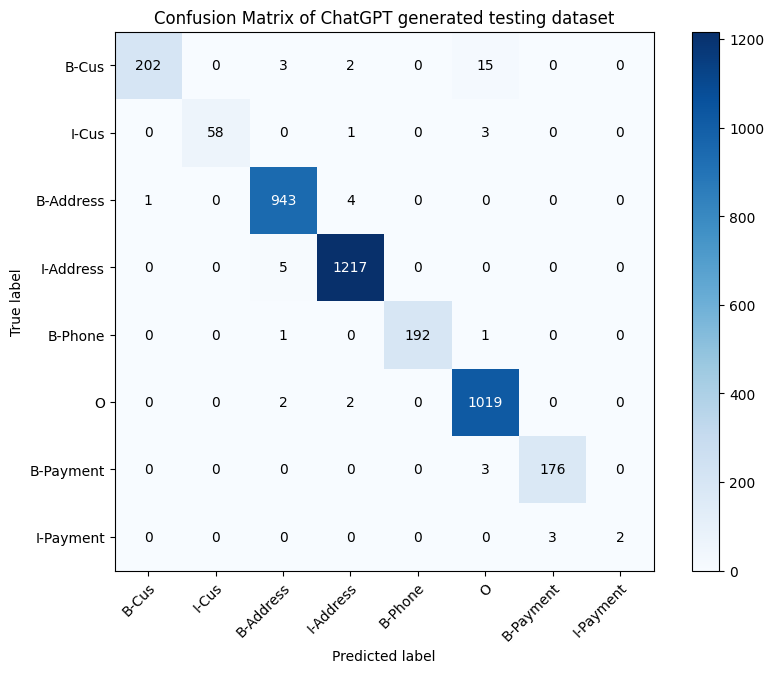

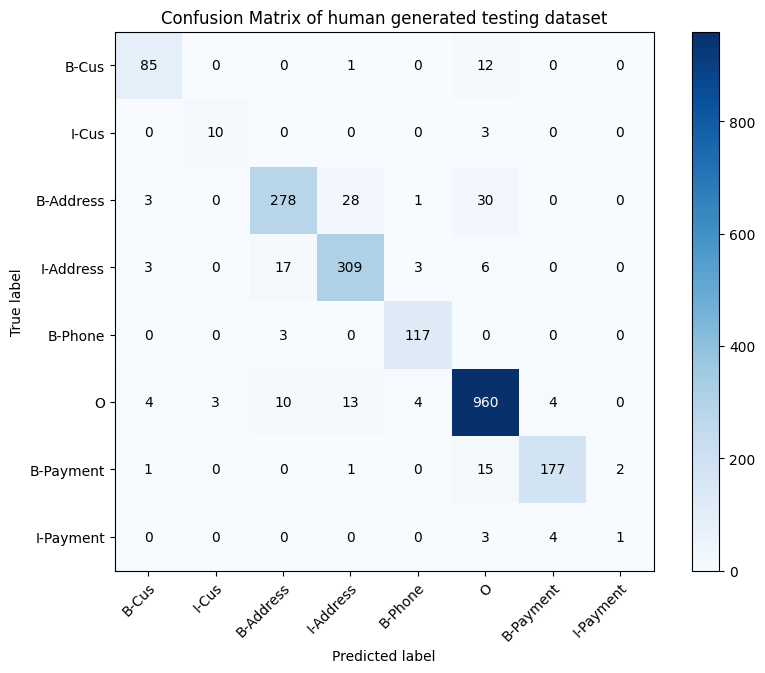

In [11]:
case_2_model.plot_confusion_matrix("../data/labeled/entity/cus_info/test_gpt.json", "ChatGPT generated testing dataset")
case_2_model.plot_confusion_matrix("../data/labeled/entity/cus_info/test_human.json", "human generated testing dataset")

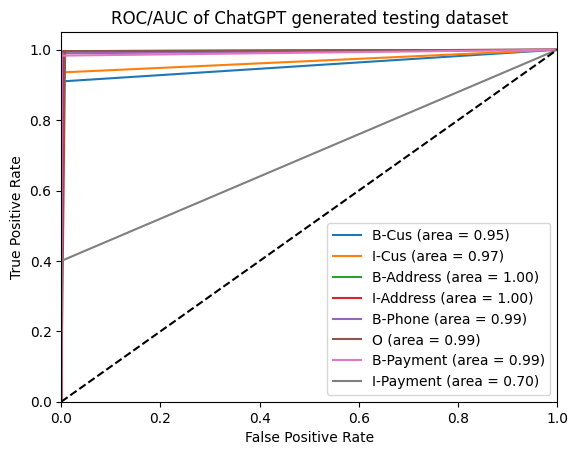

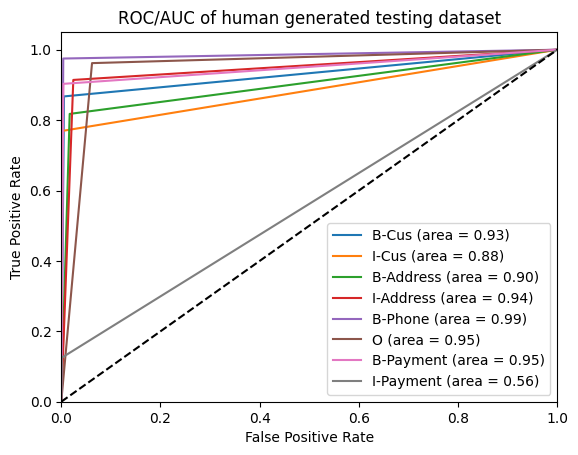

In [12]:
case_2_model.plot_roc_auc("../data/labeled/entity/cus_info/test_gpt.json", "ChatGPT generated testing dataset")
case_2_model.plot_roc_auc("../data/labeled/entity/cus_info/test_human.json", "human generated testing dataset")

#### Case 3: Combined data which is aggregated from 2 previous sources in 50-50 ratio

In [13]:
case_3_model = CRFEvaluator('../output/savedmodels/customer_info_entity_case_3.h5')

In [14]:
accuracy_on_chatgpt_test = case_3_model.evaluate_accuracy("../data/labeled/entity/cus_info/test_gpt.json")
accuracy_on_human_test = case_3_model.evaluate_accuracy("../data/labeled/entity/cus_info/test_human.json")
print("Accuracy on ChatGPT generated testing dataset: ", round(accuracy_on_chatgpt_test * 100, 2))
print("Accuracy on human written testing dataset: ", round(accuracy_on_human_test * 100, 2))

Accuracy on ChatGPT generated testing dataset:  93.88
Accuracy on human written testing dataset:  93.18


In [15]:
print("Classification report on ChatGPT generated testing dataset:")
case_3_model.print_classification_report("../data/labeled/entity/cus_info/test_gpt.json")

print("Classification report on human written testing dataset:")
case_3_model.print_classification_report("../data/labeled/entity/cus_info/test_human.json")

Classification report on ChatGPT generated testing dataset:
              precision    recall  f1-score   support

       B-Cus       0.93      0.41      0.57       222
       I-Cus       0.97      0.47      0.63        62
   B-Address       0.93      0.99      0.96       948
   I-Address       0.98      0.96      0.97      1222
     B-Phone       1.00      0.98      0.99       194
           O       0.89      0.99      0.93      1023
   B-Payment       0.98      0.99      0.99       179
   I-Payment       1.00      0.40      0.57         5

    accuracy                           0.94      3855
   macro avg       0.96      0.78      0.83      3855
weighted avg       0.94      0.94      0.93      3855

Classification report on human written testing dataset:
              precision    recall  f1-score   support

       B-Cus       0.97      0.85      0.90        98
       I-Cus       0.67      0.46      0.55        13
   B-Address       0.91      0.87      0.89       340
   I-Address    

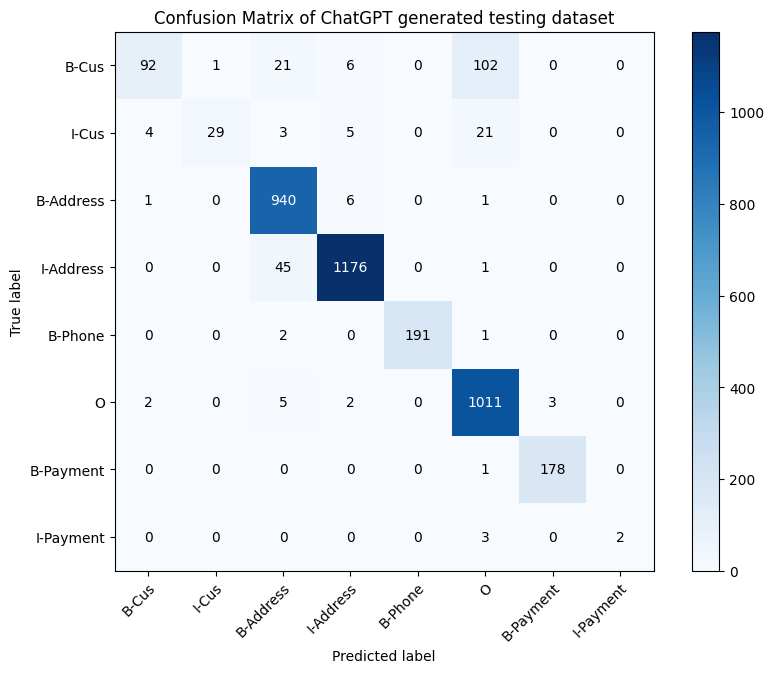

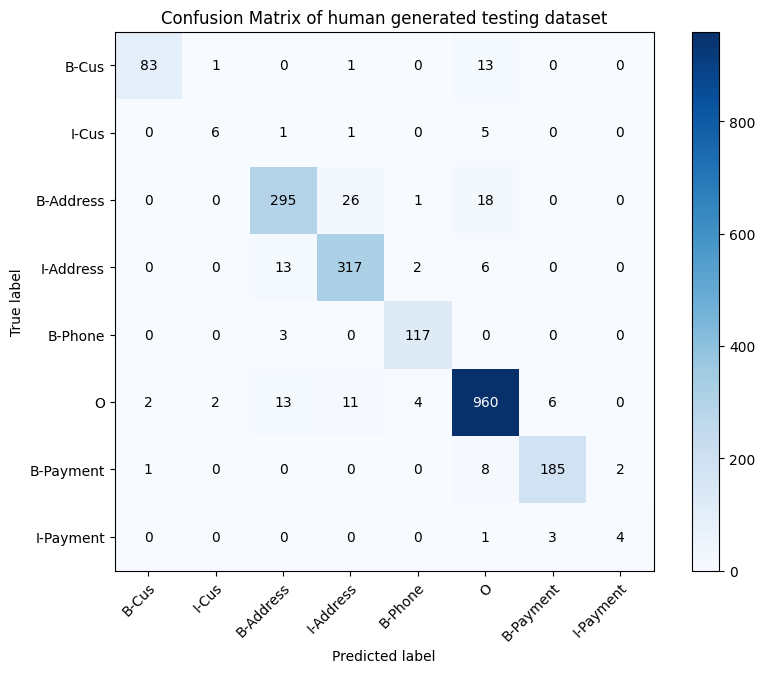

In [16]:
case_3_model.plot_confusion_matrix("../data/labeled/entity/cus_info/test_gpt.json", "ChatGPT generated testing dataset")
case_3_model.plot_confusion_matrix("../data/labeled/entity/cus_info/test_human.json", "human generated testing dataset")

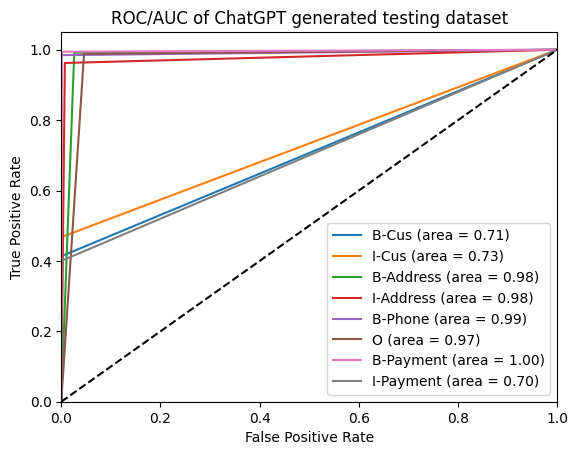

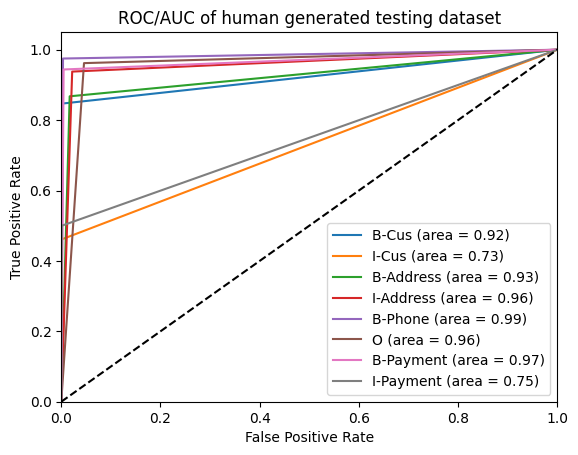

In [17]:
case_3_model.plot_roc_auc("../data/labeled/entity/cus_info/test_gpt.json", "ChatGPT generated testing dataset")
case_3_model.plot_roc_auc("../data/labeled/entity/cus_info/test_human.json", "human generated testing dataset")